# データ読み込みおよび準備

In [2]:
import pandas as pd
#%matplotlib notebook
import numpy as np
import seaborn as sns

#データ読み込み
#データのpath変えておいて
boat_path="../data/all_data.csv"
df=pd.read_csv(boat_path,encoding="shift-jis")
"""
df["belongs"]=df["belongs"].replace({"愛知":1,"三重":2})
for i,youso in enumerate(df["belongs"]):
    if type(youso)!=type(1):
        df["belongs"][i]=0
"""
#選手等級の置換
df["player_rank"]=df["player_rank"].replace({"B2":0,"B1":1,"A2":2,"A1":3})
#順位の転覆、フライングあたりを全て6位に置換してint型に
df["goal"]=df["goal"].replace({"S1":6,"S2":6,"K1":6,"K2":6,"L1":6,"L2":6})
df["goal"]=df["goal"].replace({"F":6,"S":6,"K":6,"L":6})
df["goal"]=df["goal"].astype(int)

#スタート展示でやらかしてる選手を除外
df=df[df["shinnyu"]!="L"]
df=df[df["shinnyu"]!="."]
df["shinnyu"]=df["shinnyu"].astype(int)
df=df[df["start"]!="."]
df=df[df["start"]!="K"]
df=df[df["start"]!="L"]
#スタート展示でフライングしている選手のFをマイナスに置換
df["start"]=df["start"].str.replace("F","-")
df["start"]=df["start"].astype(float)

In [3]:
df.head()

,Unnamed: 0,date,place,race_num,race_rank,position,goal,id,name,tenji,...,age,belongs,weight,player_rank,country_win,country_sub,local_win,local_sub,motor,boat
0,0,180101,常滑,1,予選,1,1,4062,後藤陽介,6.76,...,38,愛知,54,1,5.25,34.23,4.71,33.33,33.33,34.51
1,1,180101,常滑,1,予選,2,5,4915,彦坂径冶,6.79,...,21,愛知,55,0,1.34,0.00,1.58,5.56,35.71,35.96
2,2,180101,常滑,1,予選,3,2,4731,間野兼礼,6.74,...,28,愛知,51,1,3.76,16.33,5.28,33.58,8.33,41.38
3,3,180101,常滑,1,予選,4,3,3535,渡修平,6.83,...,45,兵庫,51,1,4.36,22.55,5.27,39.02,37.50,31.53
4,4,180101,常滑,1,予選,5,4,3867,松浦勝,6.76,...,42,愛知,55,1,4.69,25.26,4.88,21.74,35.71,41.03


In [5]:
df.groupby("date")

# seabornsでデータを見る

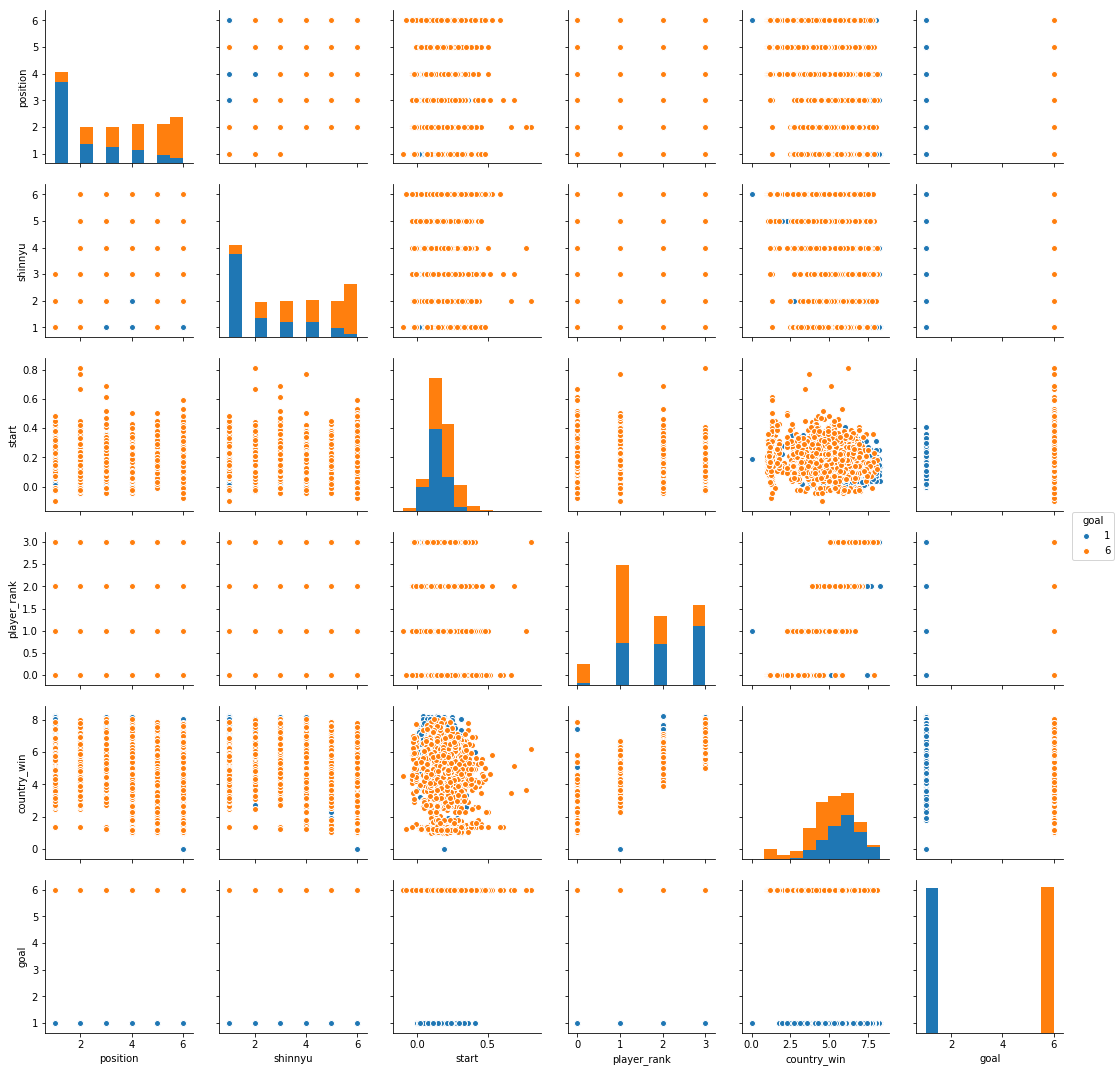

In [4]:
#print(np.logical_or(df["goal"]==1 ,df["goal"]==6))
sns.pairplot(df.loc[:,["position","shinnyu","start","player_rank","country_win","goal"]][np.logical_or(df["goal"]==1 ,df["goal"]==6)],hue="goal")

In [5]:
#class分類の時のconfusion_matrix設定(なくてもいい)
from sklearn.metrics import confusion_matrix
def show_con(pred,correct):
    label=["1_st","2_nd","3_rd","4_th","5_th","6_th"]
    label_dic={i+1:l for i,l in enumerate(label)}
    pred=pred.replace(label_dic)
    correct=correct.replace(label_dic)
    con=confusion_matrix(pred,correct,labels=label)
    print(pd.DataFrame(con, index=["１(pred)","２(pred)","３(pred)","４(pred)","５(pred)","６(pred)"],columns=["１(true)","２(true)","３(true)","４(true)","５(true)","６(true)"]))
    total=round(((np.sum(np.diag(con)))*100/np.sum(con)),2)
    first=round((con[0][0]/np.sum(con[0])*100),2)
    second=round((con[1][1]/np.sum(con[1])*100),2)
    dual=round(np.sum(con[0:2,0:2])/np.sum(con[0:2])*100,2)
    kakuren=round(np.sum(con[0:3,0:3])/np.sum(con[0:3])*100,2)
    rev_kaku=round(np.sum(con[3:,3:])/np.sum(con[3:])*100,2)
    print("総合予測率:{}%".format(total))
    print("一着予測率:{}%".format(first))
    print("二着予測率:{}%".format(second))
    print("二連複率:{}%".format(dual))
    print("拡連率:{}%".format(kakuren))
    print("逆拡連率:{}%".format(rev_kaku))

In [22]:
#レース毎に上位の予測が適切に行われたかのチェック
def show_sanren(result):
    date_list=result["date"].values.tolist()
    date_list=list(set(date_list))
    race_list=df.loc[:val,"race_num"].values.tolist()
    race_list=list(set(race_list))
    total=0
    num_cor=0
    num=3
    w_predict={1:"単勝",2:"二連複",3:"三連複"}
    for date in date_list:
        for race in race_list:
            now_res=result[result["race_num"]==race][result["date"]==date]
            truth_up=now_res["pred"]<=num
            ans=now_res["res"][truth_up]
            ans_res=all(ans<=num)
            #ans_res=collections.Counter(ans)
            #print(ans_res)

            #print("date:{0},race:{1} result".format(date,race))
            if sum(truth_up)!=num:
                #print(now_res.loc[:,["pred","res"]])
                #print("上位の予測数が違います")
                n=0
            else:
                num_cor+=1
                #デバッグ用
                #print(now_res.loc[:,["pred","res"]][truth_up])
                if ans_res:
                #if ans.values[0]<4 and ans.values[1]<4:
                    total+=1
                    
                    #print("correct")
                #else:
                    #print(now_res.loc[:,["pred","res"]][truth_up])
                    #print("wrong")
    
    print("総レース数：{}".format(len(result)/6))                
    print("予測数があっていた数:{0} , 割合：{1:.3f}".format(num_cor,num_cor/len(result)*6*100))
    print("{2}が正しく予測できた数：{0} , 割合：{1:.3f}".format(total,total/len(result)*6*100,w_predict[num]))
    print("予測数が合っていたものの中で正しく予測できたレースの割合:{0:.3f}".format(total/num_cor))

In [7]:
#予測用の関数各位
#入力：訓練データ,正解ラベル,テストデータ
#返り値：テストデータの予測結果

#linear regressionで回帰予測
from statsmodels import api as sm
def linear_reg(X,Z,testX):
    #statsmodelsで線形回帰
    #X=X.values
    model = sm.OLS(Z,sm.add_constant(X))
    result = model.fit()
    result.summary()
    
    
    coef_=result.params
    print(coef_)
    #予測結果の推定
    testX_const=testX.assign(const=1)
    t=list(range(len(X.columns)-1))
    t=[-1]+t
    testX_const=testX_const.iloc[:,t]
    tmpZ=np.array([testX_const.iloc[:,i]*coef_[i] for i in range(len(testX_const.columns))])
    predZ=np.sum(tmpZ,axis=0)
    resultZ=pd.DataFrame(np.round(predZ))
    return resultZ


#random forestで分類
from sklearn.ensemble import RandomForestClassifier
def random_forest(X,Z,testX):
    # 7~12あたりが一番性能良さそう
    model = RandomForestClassifier(max_depth=7, random_state=0)

    model.fit(X,Z)
    print(X.columns)
    print(model.feature_importances_)

    #予測結果の推定
    resultZ=model.predict(testX)
    
    return resultZ


#SVMで分類
from sklearn.svm import SVC
def SVM(X,Z,testX):
    # 線形SVMのインスタンスを生成
    model = SVC(kernel='linear', random_state=None)

    model.fit(X,Z)

    #予測結果の推定
    resultZ=model.predict(testX)
    
    return resultZ


#Kmeansで分類
from sklearn.cluster import KMeans
def K_means(X,Z,testX):
    model=KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=1000,tol=0.0001,
                 precompute_distances='auto', verbose=0,random_state=None, copy_x=True, n_jobs=1)
    model.fit(X)
    resultZ=model.predict(testX)
    return resultZ





/Users/yuta/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [23]:
import collections

#validation_dataset数の設定
val=72*20-1
#説明変数
#pred_var=list(df.columns[-7:])


pred_var=["position","shinnyu","start"]+list(df.columns[-7:-2])
#pred_var=["position","start","player_rank"]
#pred_var=["player_rank","local_win"]
trainX=df.loc[val:,pred_var]
trainZ = df.loc[val:,["goal"]]
testX=df.loc[:val,pred_var]
testZ=df.loc[:val,["goal"]]

#好きなモデルを当てはめてくれ
#predZ=linear_reg(trainX,trainZ,testX)
#predZ=SVM(trainX,trainZ,testX)
predZ=random_forest(trainX,trainZ,testX)

predZ=pd.DataFrame(predZ)
#confusion matrix レース単位無考慮
show_con(predZ,testZ)
resZ=np.array([i for i in testZ["goal"]])
result=pd.DataFrame([df.loc[:val,"date"].values,df.loc[:val,"race_num"].values,predZ[0].values,resZ],index=["date","race_num","pred","res"]).T
#レース毎の
show_sanren(result)

/Users/yuta/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Index(['position', 'shinnyu', 'start', 'player_rank', 'country_win',
       'country_sub', 'local_win', 'local_sub'],
      dtype='object')
[0.32054581 0.17558066 0.13043897 0.03093881 0.11084748 0.09251905
 0.06334461 0.07578461]
         １(true)  ２(true)  ３(true)  ４(true)  ５(true)  ６(true)
１(pred)      132       33       17       10        8       12
２(pred)       45       80       65       36       38       31
３(pred)       32       45       42       38       32       23
４(pred)       16       32       48       40       37       25
５(pred)        8       28       31       48       36       39
６(pred)        7       22       37       68       86      110
総合予測率:30.62%
一着予測率:62.26%
二着予測率:27.12%
二連複率:57.2%
拡連率:68.29%
逆拡連率:68.11%


/Users/yuta/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


総レース数：239.5
予測数があっていた数:78 , 割合：32.568
三連複が正しく予測できた数：19 , 割合：7.933
予測数が合っていたものの中で正しく予測できたレースの割合:0.244


# データを見る(おまけ)

<IPython.core.display.Javascript object>


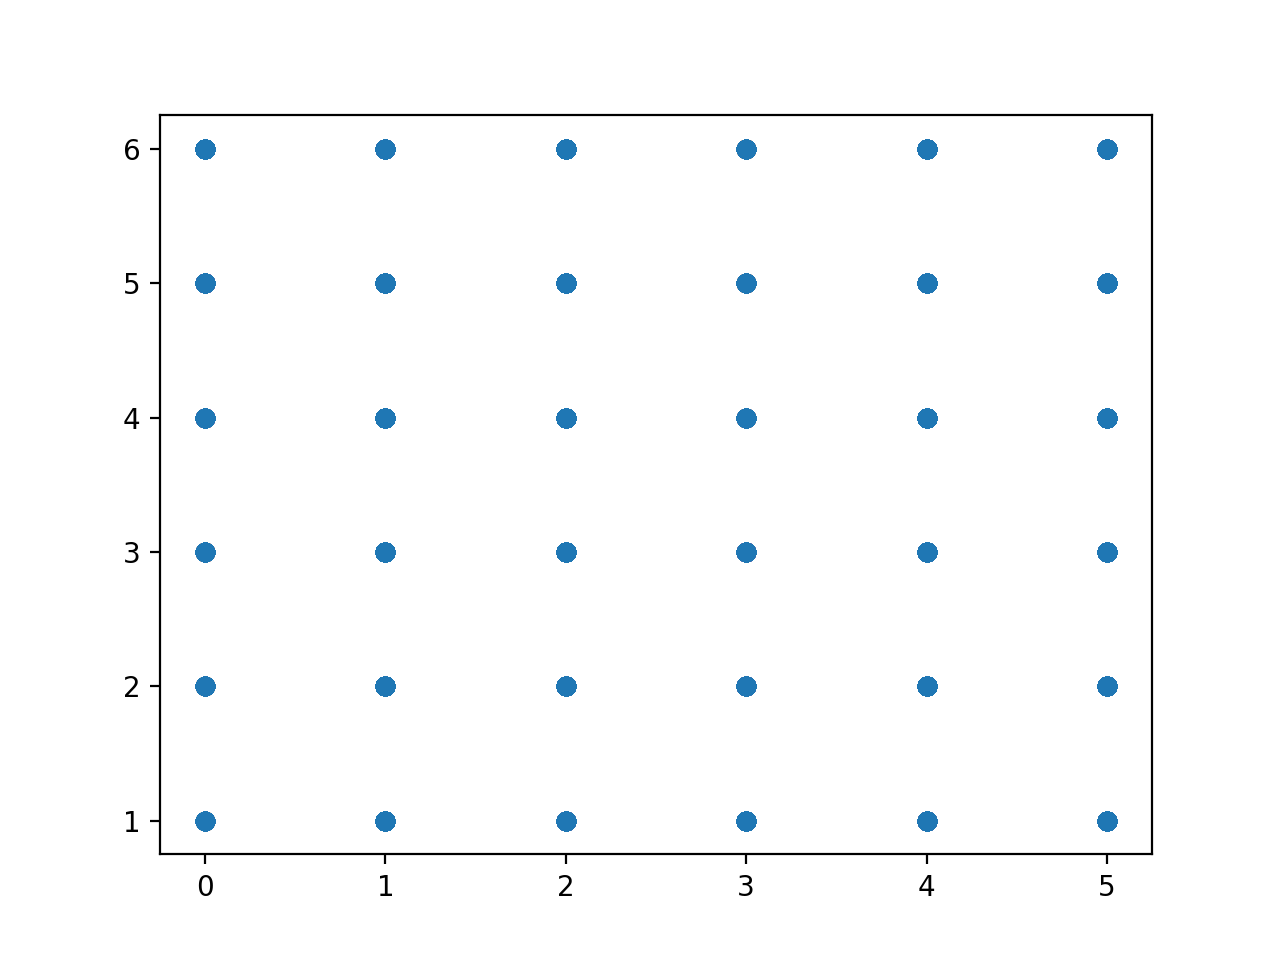

In [23]:
import matplotlib.pyplot as plt
predZ=K_means(trainX,trainZ,testX)
x_2D=predZ
y_2D=testZ
plt.plot(x_2D,y_2D,"o")

<IPython.core.display.Javascript object>


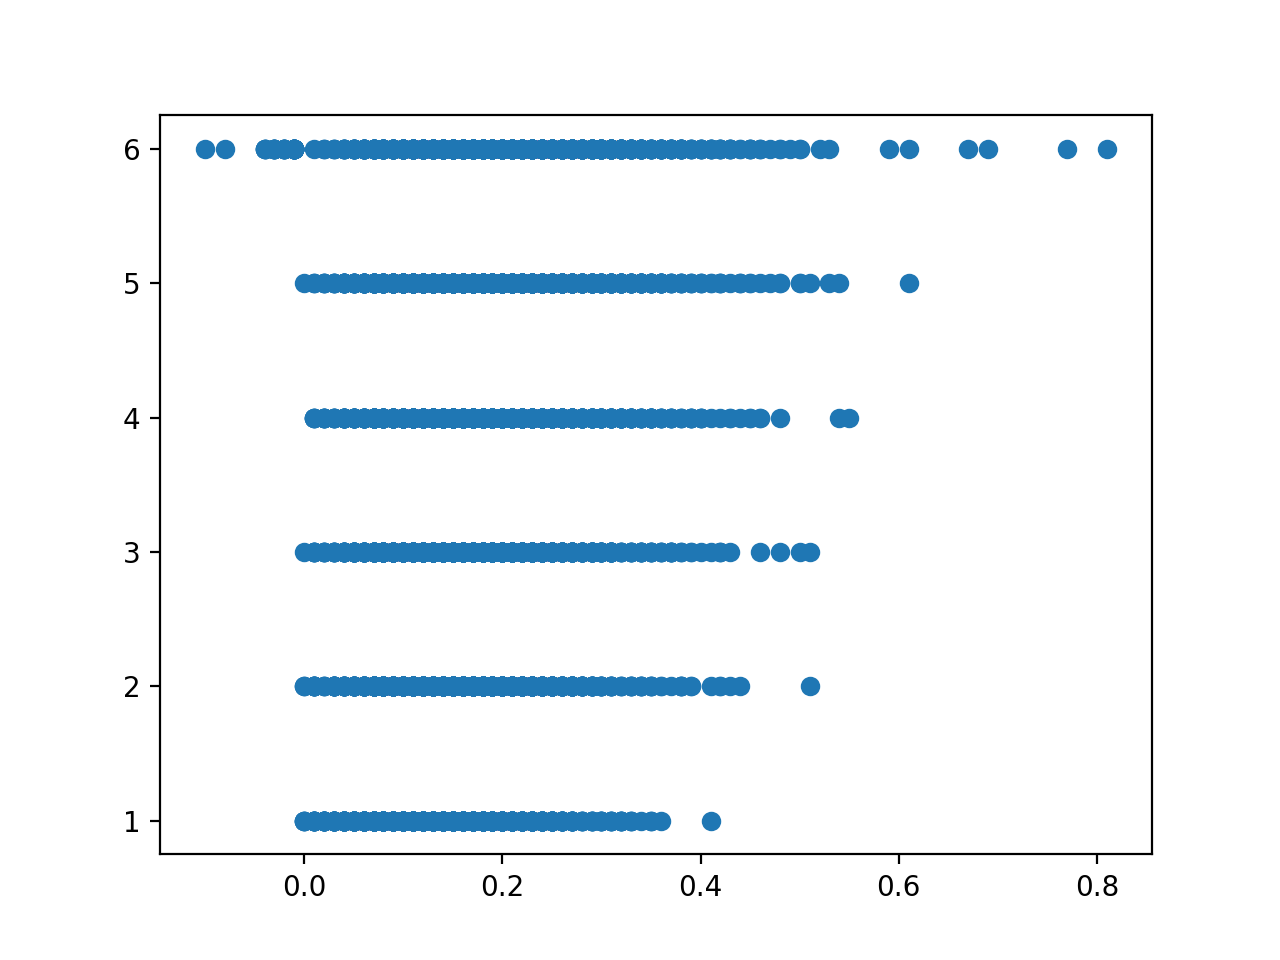

In [27]:
import matplotlib.pyplot as plt

x_2D=df["start"]
y_2D=df["goal"]
#print(len(x_2D))
plt.plot(x_2D,y_2D,"o")
plt.show()

<IPython.core.display.Javascript object>


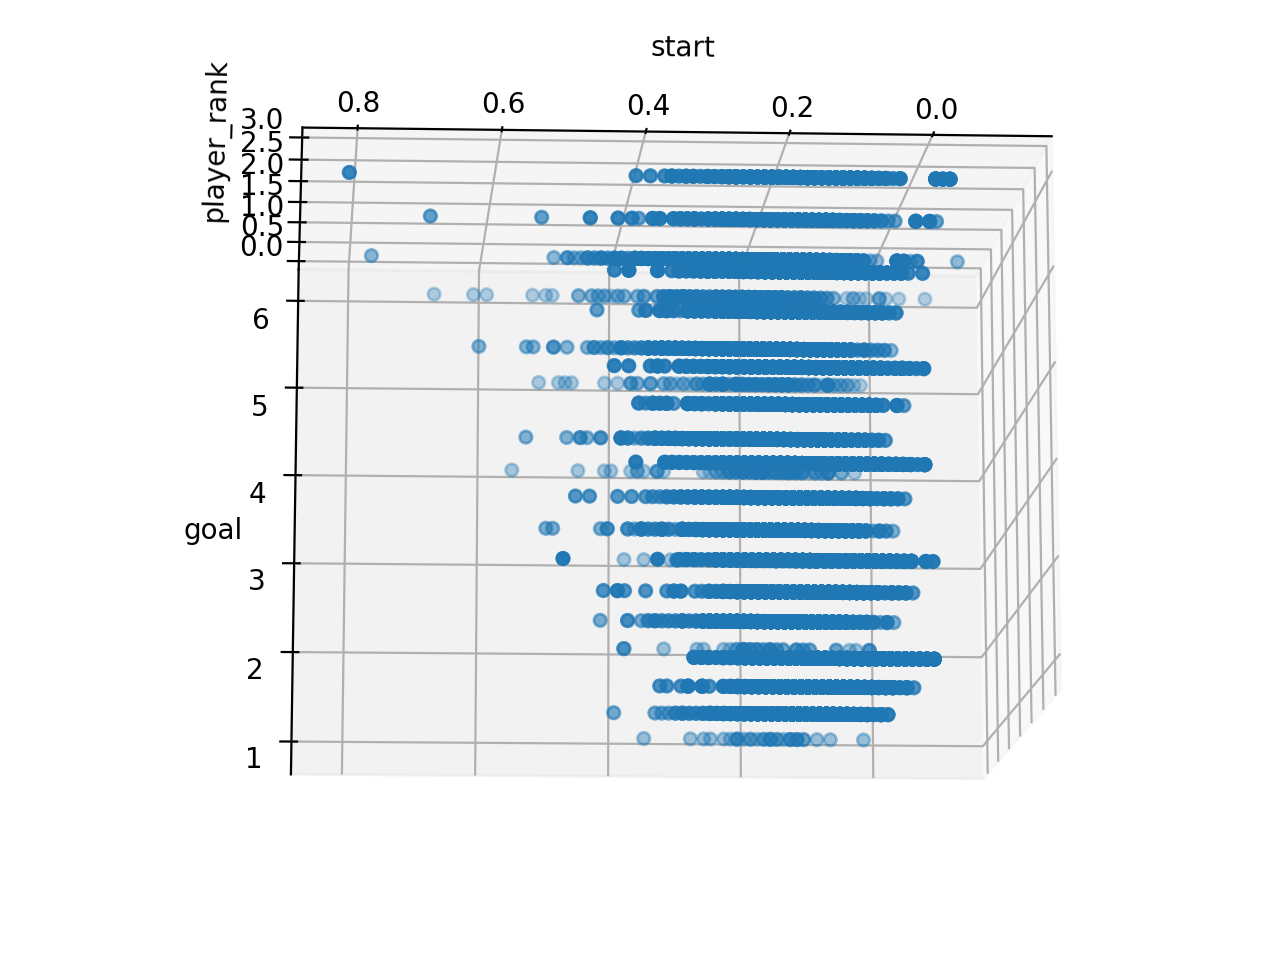

In [115]:
from mpl_toolkits.mplot3d import Axes3D

#得られたパラメータから3Dメッシュグリッドの作成
#coef_=result.params
#tmpX=df.loc[:,pred_var[0]].values
#tmpY=df.loc[:,pred_var[1]].values
tmpX=df["start"]
tmpY=df["player_rank"]
"""
meshX, meshY = np.meshgrid(tmpX,tmpY)
meshZ=4.79-meshX*0.32-meshY*0.144
"""
Z=df.loc[:,"goal"]

fig = plt.figure()
ax = Axes3D(fig)
#X_3D=df[pred_var[0]]
#Y_3D=df[pred_var[1]]
X_3D=df["start"]
Y_3D=df["player_rank"]
ax.set_xlabel(X_3D.name)
ax.set_ylabel(Y_3D.name)
ax.set_zlabel(Z.name)
ax.scatter3D(X_3D,Y_3D,Z)
#ax.contour(X_3D,Y_3D,predZ)